# Spark ML Pipeline

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

import matplotlib.pyplot as plt

import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Spark ML Pipeline") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

### Pipelines
- http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml
- 복잡한 ML 과정을 파이프라인으로 모듈화시키는 패키지

### Transformer
- Dataframe을 lazily하게 다른 dataframe으로 변형, ```transform()``` 메서드 구현
- Feature Engineering에 필요한 알고리즘
- 학습이 끝난 model

### Estimator
- Dataframe을 model에 fitting 시키는 단계, 학습시키는 알고리즘도 이에 해당
- 예를 들면 LogsiticREgression은 Estimator
- ```fit()``` 함수를 호출해 생성된 LogisticRegressionModel은 Model이자 Transformer

### Pipeline
- ML을 돌리기 위해 필요한 stage(단계)를 연결시킨 구현체
- Transformer, Estimator가 Pipeline의 각 stage에 해당
- ```Pipeline.fit()```을 호출하면 각 단계에서 지정한 함수를 순서대로 호출
- 마찬가지로 Pipelinemodel은 ```fit()``` 함수를 호출해 생성된 Model

In [4]:
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, StringIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [5]:
# K-Fold value
fold = 3

# Read train, test dataset
inputCols = ['Pclass', 'age_im', 'SibSp', 'Parch', 'Fare', 'embarked_ix', 'sex_ix', 'len_name']
str_length = udf(lambda x: len(x), IntegerType())

train = spark.read \
    .csv("/Users/byeon/Dropbox/workspace/til/data/titanic-train.csv", header=True, inferSchema=True) \
    .withColumnRenamed("Survived", "label") \
    .withColumn('len_name', str_length(col('name'))) \
    .na.drop(subset=["Embarked", "Fare"]) \
    .cache()

test = spark.read \
    .csv("/Users/byeon/Dropbox/workspace/til/data/titanic-test.csv", header=True, inferSchema=True) \
    .withColumnRenamed("Survived", "label") \
    .withColumn('len_name', str_length(col('name'))) \
    .na.drop(subset=["Embarked", "Fare"]) \
    .cache()

### Operator Define

In [7]:
imputer = Imputer(inputCols=['Age'], outputCols=['age_im'], strategy='mean')
sex_ix = StringIndexer(inputCol='Sex', outputCol='sex_ix')
embarked_ix = StringIndexer(inputCol='Embarked', outputCol='embarked_ix')
assembler = VectorAssembler(inputCols=inputCols, outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=False)
model = GBTClassifier(labelCol='label', featuresCol='scaled_features', cacheNodeIds=True)
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')

### Pipeline 설정 후 학습

In [10]:
%%time
# Pipeline
print("Make pipeline, model fitting...")
pipeline = Pipeline(
    stages=[imputer, sex_ix, embarked_ix, assembler, scaler, model])

# K-Fold Cross-validation with Parameter tuning
paramGrid = ParamGridBuilder() \
    .addGrid(model.maxDepth, [5, 7]) \
    .addGrid(model.maxIter, [20, 40]) \
    .addGrid(model.maxBins, [25]) \
    .addGrid(model.stepSize, [0.025]) \
    .addGrid(model.subsamplingRate, [0.7]) \
    .build()

# Fold 3 * Param 4 = 12
cv = CrossValidator(estimator=pipeline,
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=fold)

# Model training
cvModel = cv.fit(train)
bestModel = cvModel.bestModel

print("Model training finished!")
print("Cross-validation average score : {}".format(cvModel.avgMetrics[0]))
print("Best maxDepth parameters : {}".format(bestModel.stages[5]._java_obj.getMaxDepth()))
print("Best maxIter parameters : {}".format(bestModel.stages[5]._java_obj.getMaxIter()))
print("Best maxBins parameters : {}".format(bestModel.stages[5]._java_obj.getMaxBins()))


Make pipeline, model fitting...
Model training finished!
Cross-validation average score : 0.7848155386836968
Best maxDepth parameters : 5
Best maxIter parameters : 40
Best maxBins parameters : 25
CPU times: user 1.95 s, sys: 455 ms, total: 2.41 s
Wall time: 3min 1s


In [11]:
# Feature Importance
featureImportance = bestModel.stages[-1].featureImportances.toArray()
print("Feature importance:\n{}\n".format(
    "\n".join(map(lambda x: "{} = {}".format(str(x[0]), str(x[1])), zip(inputCols, featureImportance)))))

Feature importance:
Pclass = 0.06481750810903839
age_im = 0.22578400566966259
SibSp = 0.06989017675012926
Parch = 0.020850627057654187
Fare = 0.241193953571112
embarked_ix = 0.03151775101589472
sex_ix = 0.08440115732327731
len_name = 0.26154482050323163



In [12]:
featureImportance

array([0.06481751, 0.22578401, 0.06989018, 0.02085063, 0.24119395,
       0.03151775, 0.08440116, 0.26154482])

In [14]:
bestModel.stages

[Imputer_4481be44d6859df511fe,
 StringIndexer_4e37807cfaf4b47bb193,
 StringIndexer_4e4b915017eac3a1d0b2,
 VectorAssembler_4ed1b95cfac1b391229e,
 StandardScaler_4122b6493df4c553dfc3,
 GBTClassificationModel (uid=GBTClassifier_41a6967c367035fd406e) with 40 trees]

In [15]:
bestModel.stages[-1]

GBTClassificationModel (uid=GBTClassifier_41a6967c367035fd406e) with 40 trees

In [18]:
inputCols

['Pclass',
 'age_im',
 'SibSp',
 'Parch',
 'Fare',
 'embarked_ix',
 'sex_ix',
 'len_name']

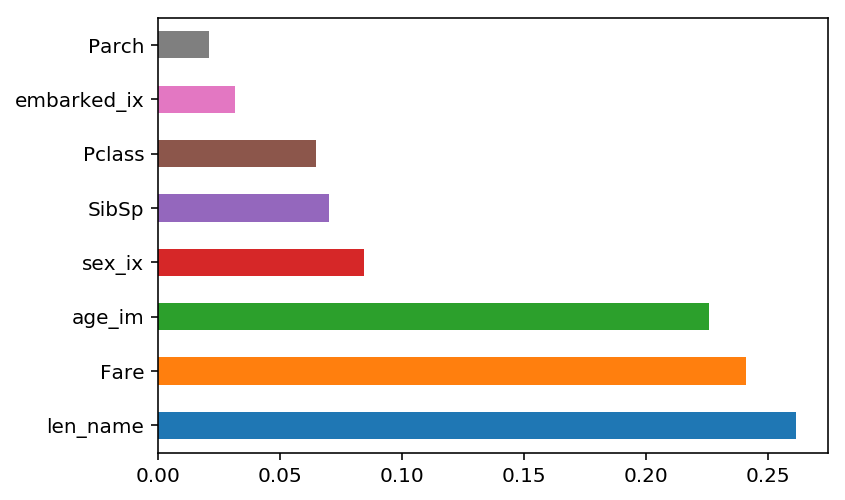

In [30]:
feat_importances = pd.Series(featureImportance, index=inputCols)
feat_importances = feat_importances.nlargest(20)
feat_importances.plot(kind='barh')

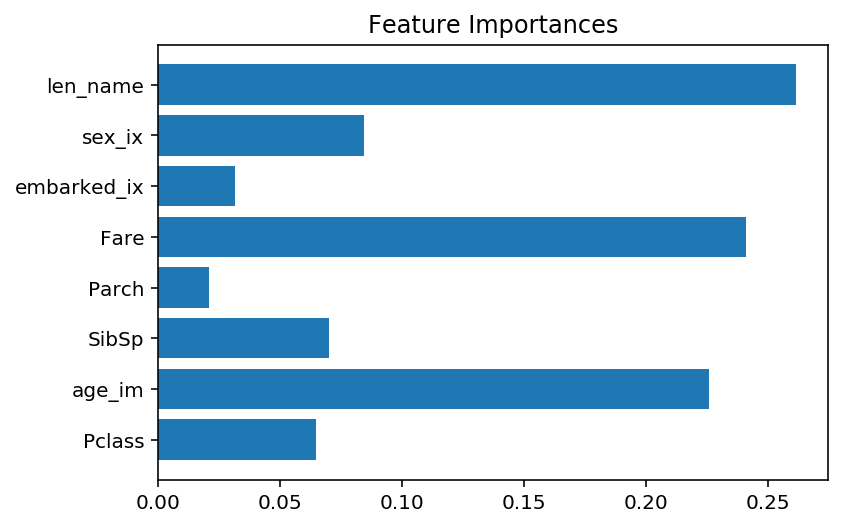

In [27]:
plt.figure()
plt.title("Feature Importances")
plt.barh(inputCols, featureImportance)
plt.show()

In [31]:
### Save Result
predict = bestModel.transform(test)
predict.select("PassengerId", "prediction") \
    .coalesce(1).write.mode("overwrite") \
    .option("compression", "gzip") \
    .csv("./pred_titanic.csv.gzip", sep=",", header=True)

print("Save to csv finished!")

Save to csv finished!


In [32]:
spark.stop()

## Reference
- 박준영님 [Repo](https://github.com/Swalloow/pyspark-ml-examples/blob/master/notebooks/spark-ml-gbt-pipeline.ipynb)